# How FUT events affect the cards prices?
# How the issue of special cards affect their normal counterparts?
# Do cards of one player with different revision follow the same pattern?*

### by *tameter_onictof*

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
pd.options.display.max_columns = 999
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

import sys
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Prepare the data

In [2]:
df_price = pd.read_csv('../data/player_price.csv',',')
df_stats = pd.read_csv('../data/player_stats.csv',',')

In [3]:
df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(["timestamp"], axis=1, inplace=True)
df_price['Year'], df_price['Month'] = df_price['Date'].dt.year, df_price['Date'].dt.month
df_price['DOW'] = df_price['Date'].dt.dayofweek

In [4]:
prices = df_price.drop(['ps_price'],axis = 1)
prices.rename(columns={'xbox_price':'price'}, inplace = True)

In [5]:
prices['Name_ID'] = prices['player_name'] + "_" +  prices['player_id'].astype(str)

In [6]:
# add mean prices of players
means = []
for player in prices.player_id.unique():
    df = prices[prices.player_id == player]
    mean_price = np.mean(df.price)
    means.append(mean_price)
df_stats['mean_price'] = pd.Series(means)

In [7]:
prices = pd.merge(prices, df_stats, \
         how = "left", on="player_id")

In [8]:
prices.head(5)

,price,player_id,player_name,Date,Year,Month,DOW,Name_ID,acceleration,aggression,agility,balance,ball,composure,crossing,curve,defending,diving,dribbling,finishing,fk,handling,heading,interceptions,jumping,kicking,long,marking,pace,passing,penalties,physicality,positioning,raits,reactions,reflexes,shooting,short,shot,sliding,specialities,speed,sprint,stamina,standing,strength,vision,volleys,cam,cb,cdm,cf,cm,lb,lf,lm,lw,lwb,rb,rf,rm,rw,rwb,st,added_on,age,att_workrate,club,def_workrate,foot,height,intl_reputation,league,name,nation,origin,revision,skills,weak_foot,weight,colour,front_scores,overall_score,position,rareness,mean_price
0,0,1,Pelé,2016-09-23,2016,9,4,Pelé_1,95,55,94,94,94,0,87,81,53,0,93,91,86,0,83,61,86,0,85,48,95,89,88,73,96,"['Leadership', 'Shooting - Finesse Shot']",96,0,89,89,84,42,"['Speedster', 'Dribbler', 'Crosser', 'Acrobat'...",0,95,88,46,71,96,90,93,63,72,93,88,72,93,92,93,76,72,93,92,93,76,90,2016-09-21,76,High,Legends,Low,Right,174,0,Legends,Pelé,Brazil,N\A,Legend,5,4,70,gold,"{'PHY': '73', 'DEF': '53', 'DRI': '94', 'PAS':...",95,CF,rare,5.244123e+06
1,10000000,1,Pelé,2016-09-24,2016,9,5,Pelé_1,95,55,94,94,94,0,87,81,53,0,93,91,86,0,83,61,86,0,85,48,95,89,88,73,96,"['Leadership', 'Shooting - Finesse Shot']",96,0,89,89,84,42,"['Speedster', 'Dribbler', 'Crosser', 'Acrobat'...",0,95,88,46,71,96,90,93,63,72,93,88,72,93,92,93,76,72,93,92,93,76,90,2016-09-21,76,High,Legends,Low,Right,174,0,Legends,Pelé,Brazil,N\A,Legend,5,4,70,gold,"{'PHY': '73', 'DEF': '53', 'DRI': '94', 'PAS':...",95,CF,rare,5.244123e+06
2,0,1,Pelé,2016-09-25,2016,9,6,Pelé_1,95,55,94,94,94,0,87,81,53,0,93,91,86,0,83,61,86,0,85,48,95,89,88,73,96,"['Leadership', 'Shooting - Finesse Shot']",96,0,89,89,84,42,"['Speedster', 'Dribbler', 'Crosser', 'Acrobat'...",0,95,88,46,71,96,90,93,63,72,93,88,72,93,92,93,76,72,93,92,93,76,90,2016-09-21,76,High,Legends,Low,Right,174,0,Legends,Pelé,Brazil,N\A,Legend,5,4,70,gold,"{'PHY': '73', 'DEF': '53', 'DRI': '94', 'PAS':...",95,CF,rare,5.244123e+06
3,0,1,Pelé,2016-09-26,2016,9,0,Pelé_1,95,55,94,94,94,0,87,81,53,0,93,91,86,0,83,61,86,0,85,48,95,89,88,73,96,"['Leadership', 'Shooting - Finesse Shot']",96,0,89,89,84,42,"['Speedster', 'Dribbler', 'Crosser', 'Acrobat'...",0,95,88,46,71,96,90,93,63,72,93,88,72,93,92,93,76,72,93,92,93,76,90,2016-09-21,76,High,Legends,Low,Right,174,0,Legends,Pelé,Brazil,N\A,Legend,5,4,70,gold,"{'PHY': '73', 'DEF': '53', 'DRI': '94', 'PAS':...",95,CF,rare,5.244123e+06
4,10000000,1,Pelé,2016-09-27,2016,9,1,Pelé_1,95,55,94,94,94,0,87,81,53,0,93,91,86,0,83,61,86,0,85,48,95,89,88,73,96,"['Leadership', 'Shooting - Finesse Shot']",96,0,89,89,84,42,"['Speedster', 'Dribbler', 'Crosser', 'Acrobat'...",0,95,88,46,71,96,90,93,63,72,93,88,72,93,92,93,76,72,93,92,93,76,90,2016-09-21,76,High,Legends,Low,Right,174,0,Legends,Pelé,Brazil,N\A,Legend,5,4,70,gold,"{'PHY': '73', 'DEF': '53', 'DRI': '94', 'PAS':...",95,CF,rare,5.244123e+06


# How FUT events affect the cards price

In [9]:
"""
    Create a quick timestamp for a certain date
"""
def tstamp(year, month, day):
    return pd.DatetimeIndex([datetime.datetime(year, month, day)])[0]

## Major FUT events

In [10]:
fut_events = {
    'Halloween start' :tstamp(2016, 10, 21), 
    'Halloween end'   :tstamp(2016, 11, 1), 
    'FUT united'      :tstamp(2016, 11, 15),
    'Black Friday'    :tstamp(2016, 11, 25),
    'Cyber Monday'    :tstamp(2016, 11, 28),
    'FUTmas start'    :tstamp(2016, 12, 16),
    'Christmas'       :tstamp(2016, 12, 25), # not an actual event, still interesting to see
    'FUTmas end'      :tstamp(2017, 1, 3),
    'Chinese new year':tstamp(2017, 1, 27), #shifted 1 day due to time difference with mainland China
    'FUT united 2nd'  :tstamp(2017, 2, 13),
    'St. Patrick'     :tstamp(2017, 3, 16),
    'FUT Birthday'    :tstamp(2017, 3, 31),
    'Community week'  :tstamp(2017, 4, 28)
}

### Separate normal and special cards
### The most expensive cards are dropped for a better visualization of the rest

In [11]:
prices_norm = prices[(prices.revision == "Normal") & (prices.mean_price < 70000)]
prices_spec = prices[(prices.revision != "Normal") & (prices.mean_price < 500000)]

### Display a part of time series of the dataframe, overlayed, 
### in order to see some general patterns along with the FUT events timestamps.

In [21]:
def massplot(df, special = False):
    # max plotted value indicator, used to set event labels properly
    max_val = 0
    cards = []
    """
        Get only a part of cards within dataset to display
        to maintain pattern visibility
    """
    if special:
        for idval in df.player_id.unique():
            cards.append(df.player_id == idval)
    else:
        for idval in range(1000):
            cards.append(df.player_id == idval)
    plt.figure(figsize(40,16))
    for card in cards[1:]:
        try:
            plt.plot(df[card].Date, df[card].price, c = 'k', linewidth = 0.65)
            try:
                if np.max(df[card].price) > max_val:
                          max_val = np.max(df[card].price)
            except ValueError:
                pass
        except TypeError:
            continue
    for text, line in fut_events.items():
        plt.axvline(line, linewidth = 0.8)
        plt.text(line + pd.Timedelta(days=1), max_val, text,rotation=90, fontsize = 22)
    plt.show()

In [ ]:
def meanplot(df, special = False):
    # mean  prices and timestamps to be plotted
    mean_prices = []
    timepoints = []
    max_val = 0
    label = 'special' if special else 'normal'

    
    # Iterate over all days of records, get mean prices
    for stamp in df.Date.unique():
        timepoint = df[df.Date == stamp]
        mean_price_today = np.mean(timepoint.price)
        mean_prices.append(mean_price_today)
        if max_val < mean_price_today:
            max_val = mean_price_today
        timepoints.append(stamp)
    plt.plot(timepoints,  mean_prices, c = 'k', linewidth = 3)
    for text, line in fut_events.items():
            plt.axvline(line, linewidth = 1.75)
            plt.text(line + pd.Timedelta(days=1), max_val * 1.007, text,rotation=90, fontsize = 30)
    plt.title("Mean prices for %s cards" % label, fontsize = 42)
    plt.show()

### Normal cards

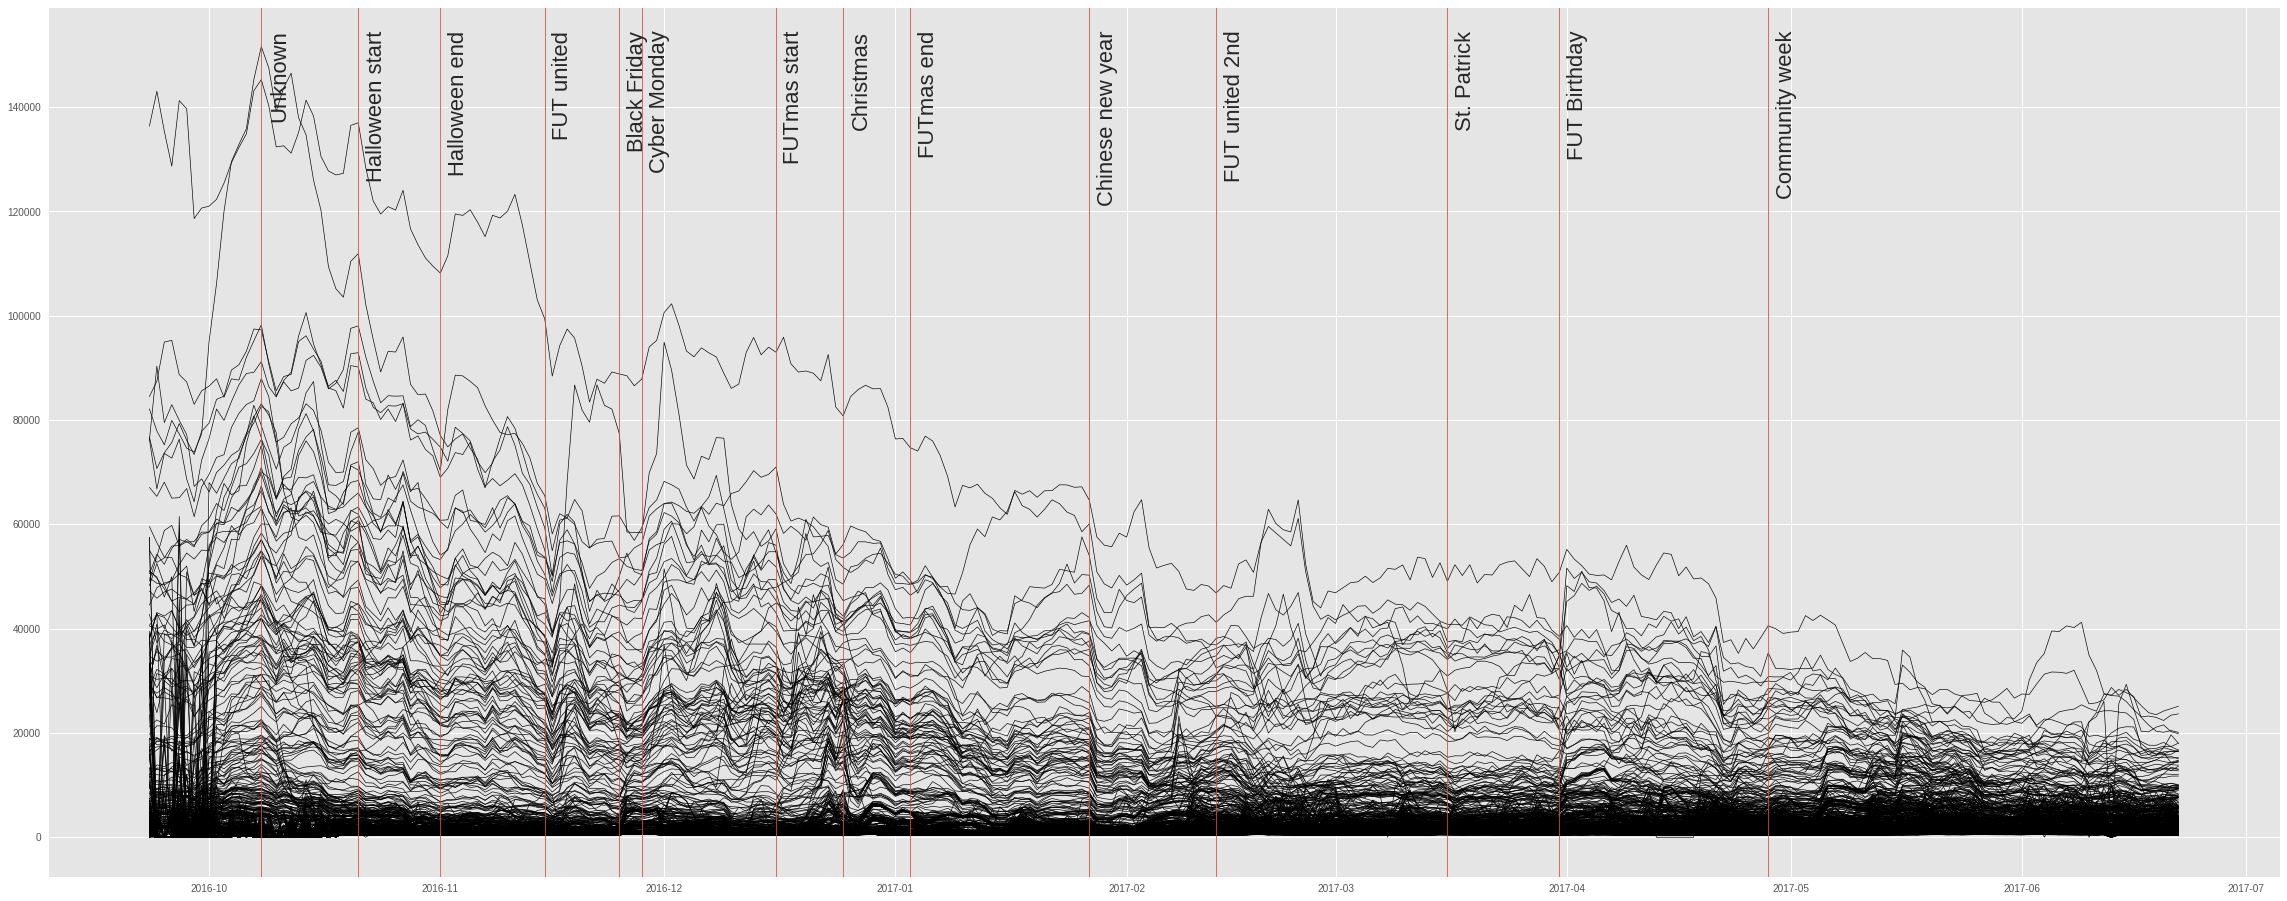

In [22]:
"""
    DOUBLE CLICK TO SEE THE FULL-SIZE PLOT
"""
massplot(prices_norm)

### FUT events generally tend to cause the prices of normal cards to drop.
* There is a stable, gradual price drop during the first big event of FUT 17 - Halloween
* The next event, FUT united, also causes the prices to drop abruptly, but the price recovers soon
* The time period between Black Friday and Cyber Monday has relatively low prices that jump right after it.
* During Christmas Eve prices are rising and fall back to the previous level right after. This may be caused by increased demand in such kind of gifts for those who enjoy the game.
* Chinese New Year caused to drop pretty damn abruptly! They seem to like football way more than I thought.
* On its birthday, FUT somehow manages to raise the prices of its cards, lol


### Special cards

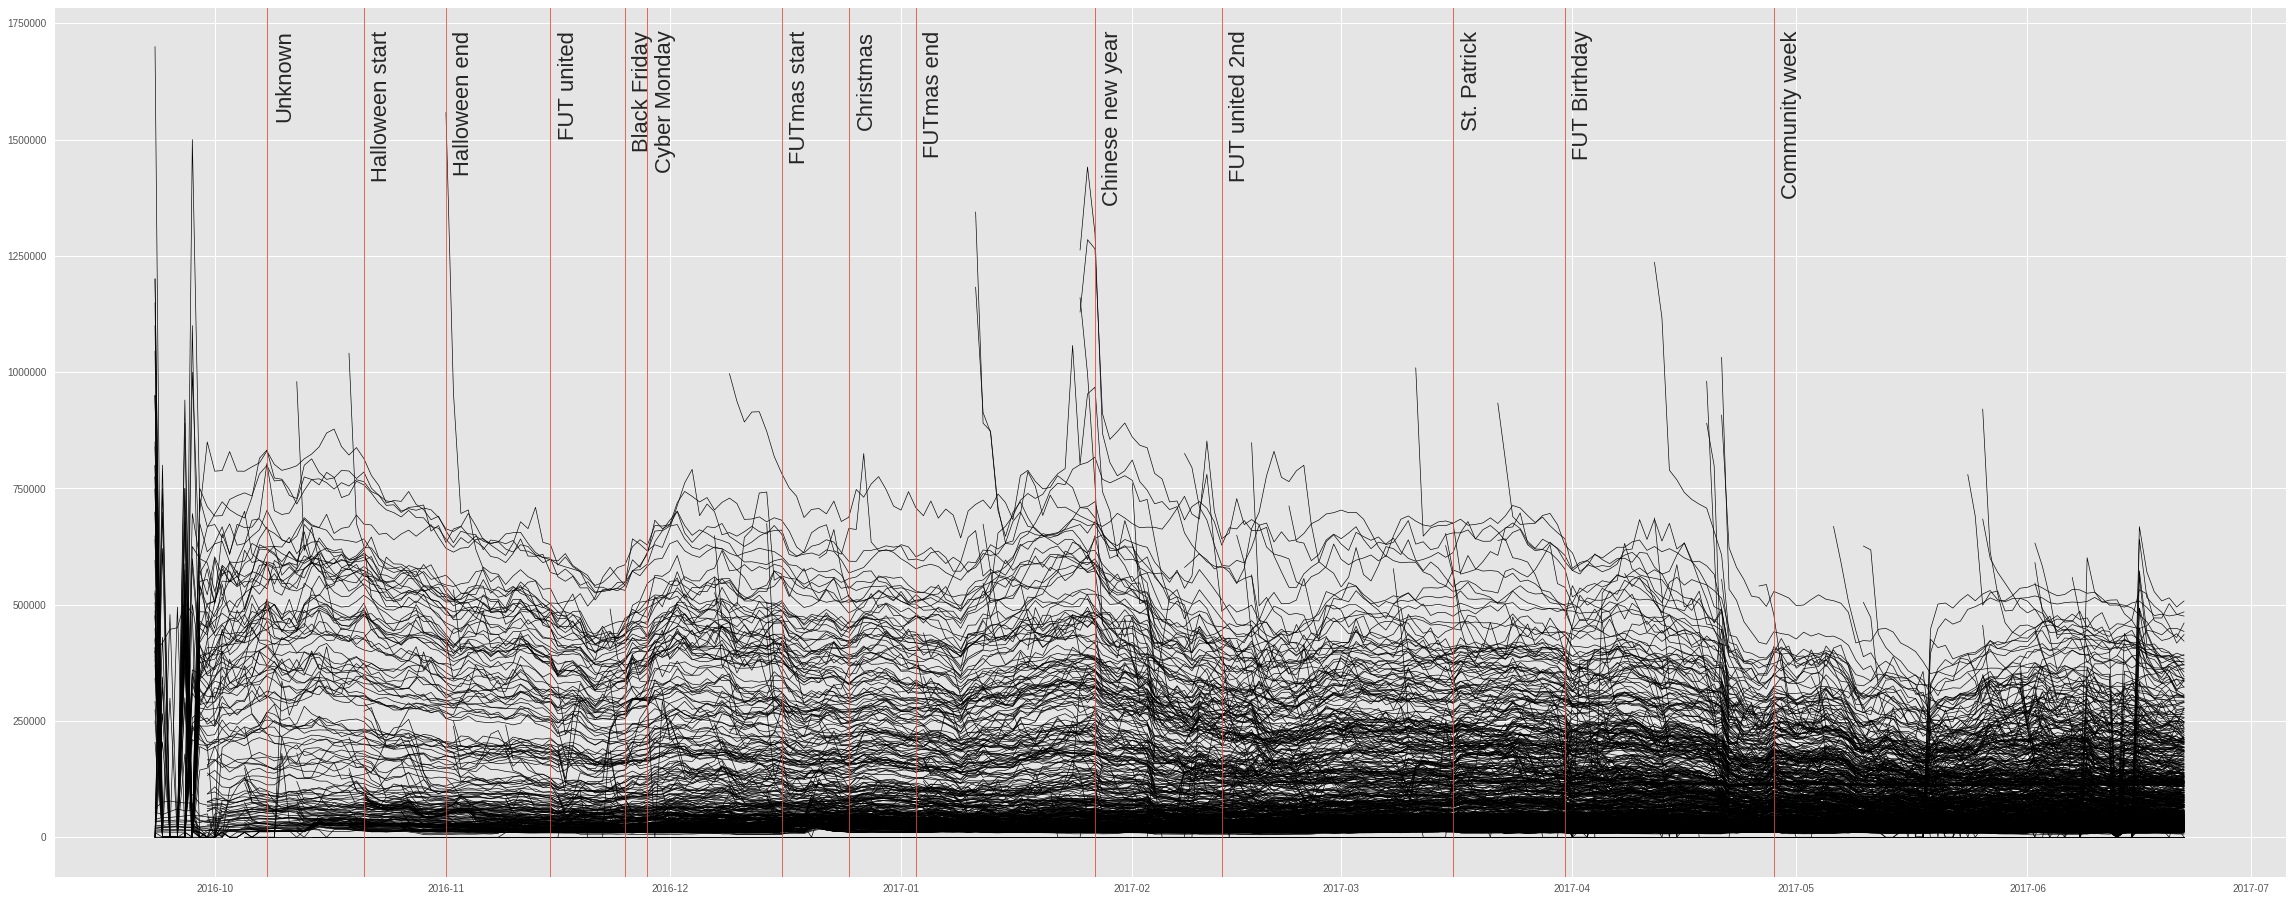

In [23]:
"""
    DOUBLE CLICK TO SEE THE FULL-SIZE PLOT
"""
massplot(prices_spec, special = True)

### As for the special cards, no strong link to events is present: prices only falling together a bit during Chinese New Year and FUT birthday, but that's it.

## How the issue of special cards affect their normal counterparts?
## Do cards of one player with different revision follow the same pattern?

In [15]:
# some dfs with top players
df_ronaldo = prices[prices.player_name == 'Cristiano Ronaldo']
df_messi = prices[prices.player_name == 'Messi']
df_robben = prices[prices.player_name == 'Robben']

In [16]:
"""
    Visualize all the time series in different colors
    with labels
"""
def vis_cards(df):
    plt.figure(figsize(15,6))
    cards = []
    for idval in df.player_id.unique():
        cards.append(df.player_id == idval)
    ax = df[cards[0]].plot(x = 'Date', y = 'price', label = df[cards[0]].revision.iloc[0])
    for card in cards[1:]:
        df[card].plot(x = 'Date', y = 'price', label = df[card].revision.iloc[0], ax = ax)
    plt.show()

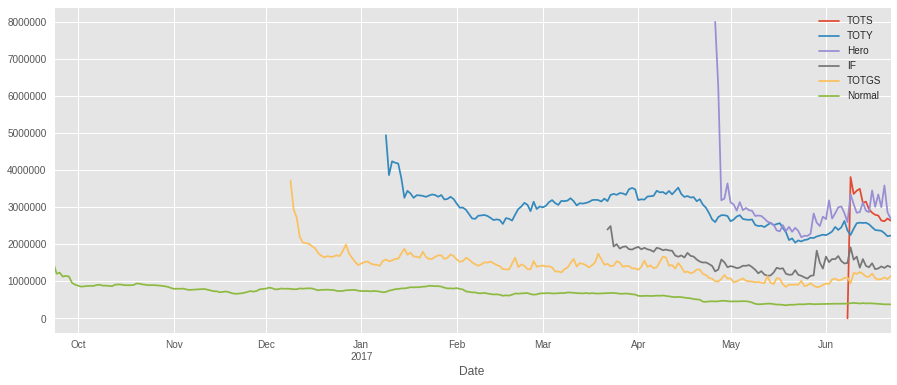

In [17]:
vis_cards(df_messi)

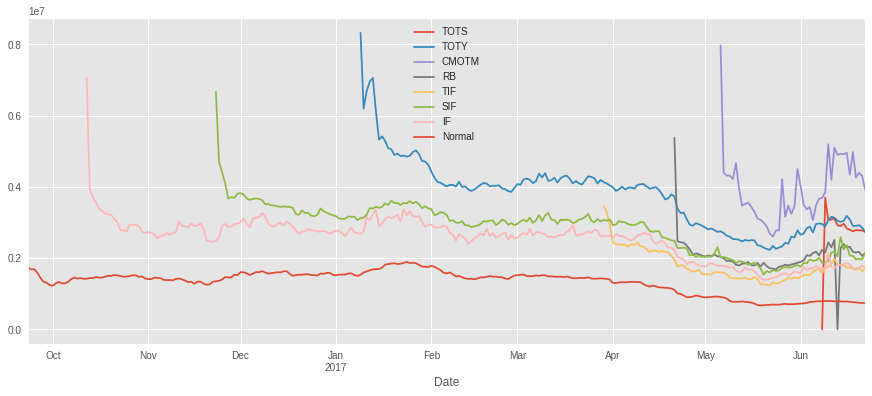

In [18]:
vis_cards(df_ronaldo)

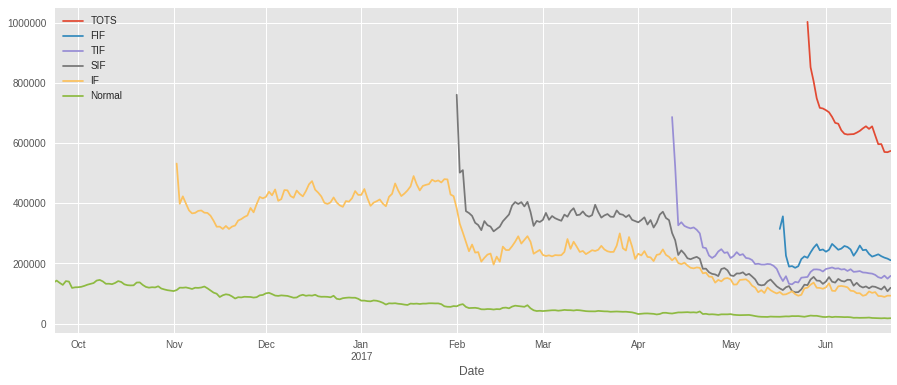

In [19]:
vis_cards(df_robben)

### Prices of the same player tend to follow the same pattern, but there is no indication of special cards changing the price behavior of the normal one.